In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt
import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
from scipy import arange, cos, exp
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.patches as patches
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from haversine import haversine, Unit
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import rankdata


from matplotlib import colors as c
import csv
import pandas as pd

import matplotlib as mpl

import cc3d
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import matplotlib as mpl
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.colors import from_levels_and_colors
import random
import cmaps


# land mask, time and spatial information, aridity index

In [2]:
NCname = '/Net/Groups/data_BGC/era5/e1/0d25_daily/t2mmax/t2mmax.daily.an.era5.1440.720.1950.nc'
NCData = Dataset(NCname)
lon_era5 = NCData.variables['longitude'][:]
lat_era5 = NCData.variables['latitude'][:]
LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
var = NCData.variables['t2mmax'][0]
NCData.close()


In [3]:
lon_era5 

masked_array(data=[-179.875, -179.625, -179.375, ...,  179.375,  179.625,
                    179.875],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [4]:
NCname = '/Net/Groups/BGI/scratch/yt/data/era5_land_surface_mask.nc'
NCData = Dataset(NCname)
land_mask = np.squeeze(NCData.variables['lsm'][:])
lon_era50 = NCData.variables['longitude'][:]
lat_era50 = NCData.variables['latitude'][:]
NCData.close()
land_mask = np.concatenate((land_mask[:,720:] ,land_mask[:,:720]),axis=1 )
lon_era50 = np.concatenate((lon_era50[720:]-360 ,lon_era50[:720]) )

In [5]:
LAT_era5[LAT_era5>np.nanmax(lat_era50)] = np.nanmax(lat_era50)
LAT_era5[LAT_era5<np.nanmin(lat_era50)] = np.nanmin(lat_era50)
LON_era5[LON_era5>np.nanmax(lon_era50)] = np.nanmax(lon_era50)
LON_era5[LON_era5<np.nanmin(lon_era50)] = np.nanmin(lon_era50)

In [6]:

my_interpolating_function = RegularGridInterpolator((lat_era50[::-1],lon_era50), land_mask[::-1])
land_mask  = my_interpolating_function((LAT_era5.ravel(), LON_era5.ravel())).reshape((len(LAT_era5[:,0]),len(LON_era5[0])))


In [7]:
year_era5_all = []
mon_era5_all = []
day_era5_all = []
for i_year in range(1979,2021):
    NCname = '/Net/Groups/data_BGC/era5/e1/0d25_daily/t2mmax/t2mmax.daily.an.era5.1440.720.'+str(i_year)+'.nc'
    NCData = Dataset(NCname)

    time = NCData.variables['time']
    dates = list(num2date(time[:], time.units, time.calendar))
    year_era5 = np.array([date.year for date in dates])
    mon_era5 = np.array([date.month for date in dates])
    day_era5 = np.array([date.day for date in dates])
    md_era5 = 100*np.array(mon_era5)+np.array(day_era5)
    year_era5 = np.squeeze(np.array(year_era5)[md_era5!=229])
    mon_era5 = np.squeeze(np.array(mon_era5)[md_era5!=229])
    day_era5= np.squeeze(np.array(day_era5)[md_era5!=229])
    year_era5_all.extend(year_era5)
    mon_era5_all.extend(mon_era5)
    day_era5_all.extend(day_era5)
    #var= np.squeeze(var[md_era5!=229])
year_era5_all = np.array(year_era5_all )
mon_era5_all = np.array(mon_era5_all )
day_era5_all = np.array(day_era5_all )

In [8]:
def remove_seasonal(var):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [9]:
def remove_seasonal_normalized(var):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = (temp - np.array(len(temp)*[np.nanmean(temp,axis=0)]))/np.array(len(temp)*[np.nanstd(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend 

In [10]:
def SEB_ano(var,skt):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(42)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp1 =  np.array([skt[365*i_year+i_box] for i_year in range(42)])
        temp1 = np.array(len(temp1)*[np.nanmean(temp1,axis=0)])
        temp = temp/(4*5.68*1e-8*temp1**3)
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(42):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend

# one heatwave as whole

In [11]:

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/')
leastdate = 5

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree')
HW_date = []
HW_lat = []
HW_lon = []
HW_location_lat = []
HW_location_lon = []
HW_duration = []
HW_aera = []
HW_date_centroid = []
HW_location_centroid = []
for fl in filelist:
    if fl[-4:] != '.csv':
        continue
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/' + fl
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            if i_row in [6,7,8]:
                all.append(np.array([ round(float(i)) for i in row]))
            else:
                all.append(np.array([ int(i) for i in row]))
    if all[5]<leastdate:
        continue
    if all[6]<40000:
        continue
    if   lat_era5[int(all[8][0])]<-23.5:
        if mon_era5_all[int(all[7])] not in [12,1,2]:
            continue
    if   lat_era5[int(all[8][0])]>=23.5:
        if mon_era5_all[int(all[7])] not in [6,7,8]:
            continue
    HW_date.append(all[0])
    HW_lat.append(all[1])
    HW_lon.append(all[2])
    HW_location_lat.append(all[3])
    HW_location_lon.append(all[4])   
    HW_duration.append(all[5])
    HW_aera.append(all[6])
    HW_date_centroid.append(all[7])
    HW_location_centroid.append(all[8])
    #print(all[0])
    #print(all[1])
    #print(all[2])
print(len(HW_date))
#%%
HW_duration = np.squeeze(np.array(HW_duration))
HW_aera = np.squeeze(np.array(HW_aera))
HW_date_centroid = np.squeeze(np.array(HW_date_centroid))
HW_location_centroid = np.squeeze(np.array( HW_location_centroid ))

HW_center_lon = np.array([lon_era5[i] for i in HW_location_centroid[:,1]])
HW_center_lat = np.array([lat_era5[i] for i in HW_location_centroid[:,0]])
#%%

3454


/tmp/ipykernel_380671/1109865123.py:7: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("precip3_16lev").copy()
  cmap.set_bad('#d4d4d4',np.nan)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python3

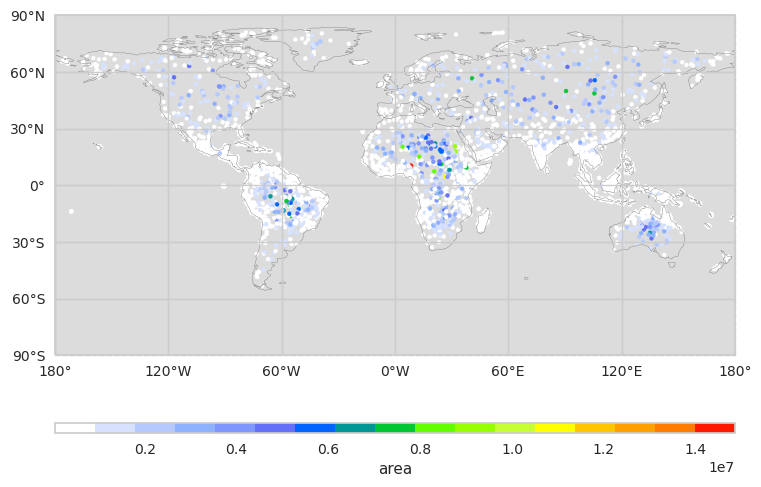

In [12]:

cmap =cmaps.precip3_16lev
fig= plt.figure(figsize=(8, 5))
proj = ccrs.PlateCarree(central_longitude=0)##
ax = plt.axes([0.1, 0.2, 0.85, 0.77],projection = proj)
ax.set_facecolor('#DCDCDC')

cmap.set_bad('#d4d4d4',np.nan)

#con  = ax.contourf(LON_era5,LAT_era5,con_value,cmap=cmap)
levels = MaxNLocator(nbins=14).tick_values(0, 1000000)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
#im = ax.pcolormesh(LON_era5,LAT_era5, con_value, cmap=cmap, norm=norm)

#im = ax.contourf(LON_cmip6,LAT_cmip6, con_value, extend='both', cmap=cmap)
im = ax.scatter(HW_center_lon  ,HW_center_lat,c = HW_aera, cmap=cmap,s=8)
ax.coastlines(color='grey')
ax.gridlines()
ax.set_xticks([-180, -120, -60,0, 60, 120, 180, ], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                number_format='.0f')
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')
#ax.add_patch(rect)
cax = plt.axes([0.1, 0.09, 0.85, 0.02])
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
#ax1.grid(b=False)

cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
cbar.set_label('area')


ax.grid(linestyle='--')




# Heat wave event indices

In [13]:

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/')
leastdate = 5

filelist = os.listdir(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree')
HW_date = []
HW_lat = []
HW_lon = []
HW_location_lat = []
HW_location_lon = []
HW_duration = []
HW_aera = []
HW_date_centroid = []
HW_location_centroid = []
for fl in filelist:
    if fl[-4:] != '.csv':
        continue
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_event_025_degree/' + fl
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            if i_row in [6,7,8]:
                all.append(np.array([ round(float(i)) for i in row]))
            else:
                all.append(np.array([ int(i) for i in row]))
    if all[5]<leastdate:
        continue
    if all[6]<40000:
        continue
    if   lat_era5[int(all[8][0])]<-23.5:
        if mon_era5_all[int(all[7])] not in [12,1,2]:
            continue
    if   lat_era5[int(all[8][0])]>=23.5:
        if mon_era5_all[int(all[7])] not in [6,7,8]:
            continue
    HW_date.append(all[0])
    HW_lat.append(all[1])
    HW_lon.append(all[2])
    HW_location_lat.append(all[3])
    HW_location_lon.append(all[4])   
    HW_duration.append(all[5])
    HW_aera.append(all[6])
    HW_date_centroid.append(all[7])
    HW_location_centroid.append(all[8])
    #print(all[0])
    #print(all[1])
    #print(all[2])
print(len(HW_date))
#%%
HW_duration = np.squeeze(np.array(HW_duration))
HW_aera = np.squeeze(np.array(HW_aera))
HW_date_centroid = np.squeeze(np.array(HW_date_centroid))
HW_location_centroid = np.squeeze(np.array( HW_location_centroid ))
#%%

3454


In [14]:
HW_duration = np.squeeze(np.array(HW_duration))
HW_aera = np.squeeze(np.array(HW_aera))
HW_date_centroid = np.squeeze(np.array(HW_date_centroid))
HW_location_centroid = np.squeeze(np.array( HW_location_centroid ))

HW_year = np.array([year_era5_all[i] for i in HW_date_centroid])
HW_mon = np.array([mon_era5_all[i] for i in HW_date_centroid])
HW_day = np.array([day_era5_all[i] for i in HW_date_centroid])

HW_center_lon = np.array([lon_era5[i] for i in HW_location_centroid[:,1]])
HW_center_lat = np.array([lat_era5[i] for i in HW_location_centroid[:,0]])

HW_location_lon = np.array([lon_era5[i] for i in HW_lon])
HW_location_lat = np.array([lat_era5[i] for i in HW_lat])

/tmp/ipykernel_380671/2631722566.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_location_lon = np.array([lon_era5[i] for i in HW_lon])
/tmp/ipykernel_380671/2631722566.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_location_lat = np.array([lat_era5[i] for i in HW_lat])


In [15]:
event_N = len(HW_duration)
print( 'extreme event n = ' +str(event_N))

extreme event n = 3454


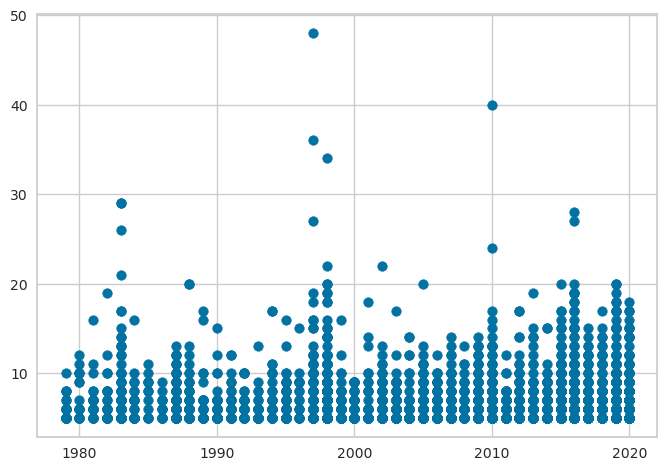

In [16]:
plt.scatter(HW_year,HW_duration)

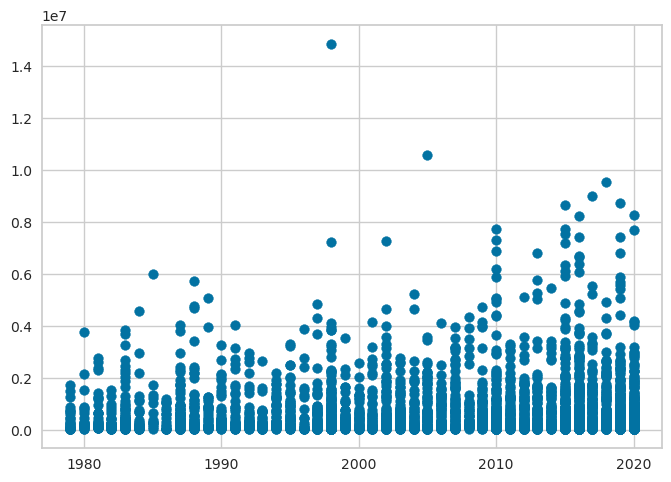

In [17]:
plt.scatter(HW_year,HW_aera)

(array([ 176.,  142.,  158.,  155.,  410.,  246.,  294.,  408.,  452.,
        1013.]),
 array([1979. , 1983.1, 1987.2, 1991.3, 1995.4, 1999.5, 2003.6, 2007.7,
        2011.8, 2015.9, 2020. ]),
 <BarContainer object of 10 artists>)

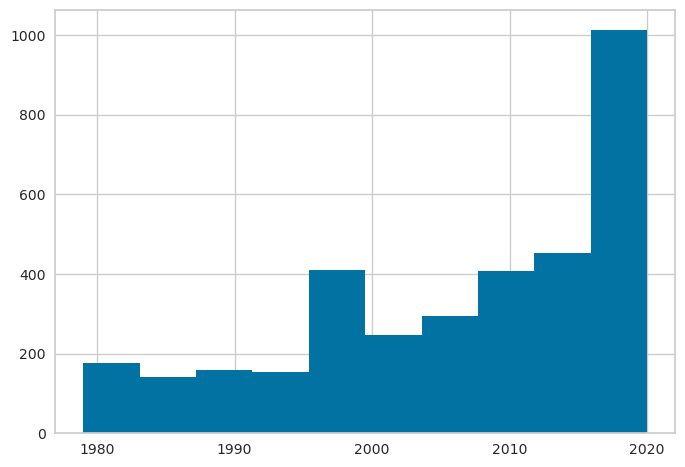

In [18]:
plt.hist(HW_year)

In [39]:
# HW_extent = []
# for i_lat, i_lon in zip(HW_location_lat,HW_location_lon):
#     hor_set = []
#     for i,j in zip(i_lat,i_lon):
#         if (i,j) not in hor_set:
#             hor_set.append((i,j) )
#     HW_extent.append(len(hor_set))
# HW_extent = np.array(HW_extent)
# data = np.array([ HW_extent]).T

In [19]:
HW_year_max = np.array([year_era5_all[np.nanmax(i)] for i in HW_date])
HW_mon_max = np.array([mon_era5_all[np.nanmax(i)] for i in HW_date])
HW_day_max = np.array([day_era5_all[np.nanmax(i)] for i in HW_date])

HW_year_min = np.array([year_era5_all[np.nanmin(i)] for i in HW_date])
HW_mon_min = np.array([mon_era5_all[np.nanmin(i)] for i in HW_date])
HW_day_min = np.array([day_era5_all[np.nanmin(i)] for i in HW_date])

HW_day_duration_str = np.array([str(i)+'-'+str(j) for i,j in zip(HW_year_min*10000+HW_mon_min*100+HW_day_min,HW_year_max*10000+HW_mon_max*100+HW_day_max)])

In [20]:

HW_year_all = np.array([year_era5_all[i] for i in HW_date])
HW_mon_all = np.array([mon_era5_all[i] for i in HW_date])
HW_ym = []
for i_year,i_mon in zip(HW_year_all ,HW_mon_all):
    i_ym = (i_year-1979)*12+i_mon
    HW_ym.append(i_ym)
HW_ym = np.array(HW_ym)

/tmp/ipykernel_380671/1058730609.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_year_all = np.array([year_era5_all[i] for i in HW_date])
/tmp/ipykernel_380671/1058730609.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_mon_all = np.array([mon_era5_all[i] for i in HW_date])
/tmp/ipykernel_380671/1058730609.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtyp

# SEB


In [21]:
vername = '_235'
var = 'skt'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_skt_all = copy.deepcopy(all) 

var = 't2m'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_t2m_all = copy.deepcopy(all) 


vername = '_235'
var = 'dia'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_dia_all = copy.deepcopy(all) 

var = 'ssr'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_ssr_all = copy.deepcopy(all)

#

var = 'strd'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_strd_all = copy.deepcopy(all)

#

var = 'sshf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_sshf_all = copy.deepcopy(all)

#

var = 'slhf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_slhf_all = copy.deepcopy(all)


var = 'adv'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_adv_all = copy.deepcopy(all)

var = 'adiabatic'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row]))
HW_adiabatic_all = copy.deepcopy(all)




HW_q_all = []  
for iii in range(len(HW_slhf_all)):
    HW_q_all.append(HW_skt_all[iii]-HW_ssr_all[iii]-HW_strd_all[iii]-HW_slhf_all[iii]-HW_sshf_all[iii])



In [22]:

var = 'AI'
flname = '/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_AI_ano_6days_all_235.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_AI_all = copy.deepcopy(all)

In [23]:
len(HW_ssr_all)

3454

In [24]:
HW_skt_all_all = []
for i in HW_skt_all:
    HW_skt_all_all.extend(i)
HW_t2m_all_all = []
for i in HW_t2m_all:
    HW_t2m_all_all.extend(i)

In [25]:
len(HW_skt_all_all)

8463177

In [26]:
X = np.array(HW_skt_all_all)
y = np.array(HW_t2m_all_all)

reg = LinearRegression().fit(X.reshape(1, -1).T, y)
slope_p = reg.coef_
r_p=reg.score(X.reshape(1, -1).T, y)
print(reg.coef_,reg.score(X.reshape(1, -1).T, y))


[0.90826558] 0.8602109593541893


/tmp/ipykernel_380671/2268672334.py:41: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


[0.90892478] 0.8611843411174361


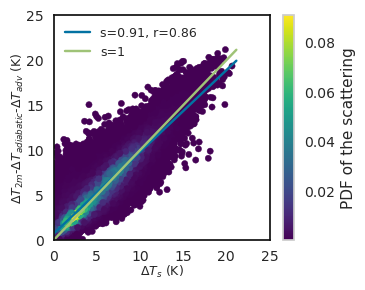

In [27]:
# HW_Meteoro
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
fig= plt.figure(figsize=(4.5, 3))
ax = plt.axes([0.2, 0.2, 0.6, 0.75])

# Generate fake data
X = np.array(HW_skt_all_all)[::40]
y = np.array(HW_t2m_all_all)[::40]
# n = np.where((~np.isnan(X))&(~np.isnan(y)))[0]
# X=X[n]
# y=y[n]
# Calculate the point density
xy = np.vstack([X,y])
z = gaussian_kde(xy)(xy)


sc = ax.scatter(X, y, c=z, s=20,cmap='viridis')
plt.colorbar(sc,label='PDF of the scattering')
reg = LinearRegression().fit(X.reshape(1, -1).T, y)
print(reg.coef_,reg.score(X.reshape(1, -1).T, y))


temp1 = np.nanmin(X)-0.5
temp2 =  np.nanmax(X)+0.5
ax.plot(np.array([temp1,temp2]),np.array([temp1,temp2])*reg.coef_+reg.intercept_,label='s='+'%.2f'%slope_p+', r='+'%.2f'%r_p)


ax.plot(np.array([temp1,temp2]),np.array([temp1,temp2]),label='s=1')

ax.set_ylabel('$\Delta$$T_{2m}$-$\Delta$$T_{adiabatic}$-$\Delta$$T_{adv}$ (K)',labelpad=-0.01,fontsize=9) 
ax.set_xlabel('$\Delta$$T_{s}$ (K)',labelpad=-0.01,fontsize=9) 

for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')
ax.grid(b=False)
plt.legend(loc='upper left',fontsize=9)
ax.set_xlim(0,20)
ax.set_ylim(0,20)
plt.xticks(np.arange(0,26,5))
plt.yticks(np.arange(0,26,5))
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/t2m_skt_025.jpg', dpi=300)

# Contribution of different component

plot T2m


/tmp/ipykernel_3815113/438583306.py:40: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("cmp_flux").copy()
  cmap.set_bad('#d4d4d4',np.nan)


[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
findfont: Fon

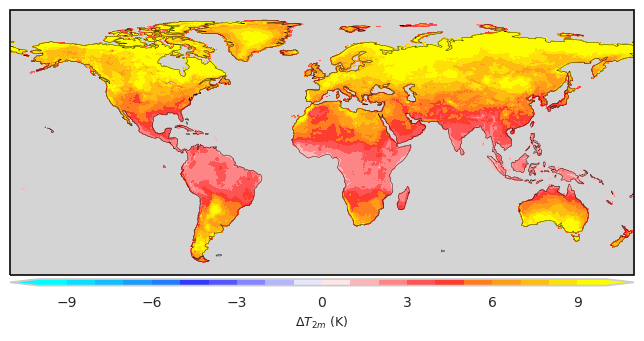

plot Diabatic
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


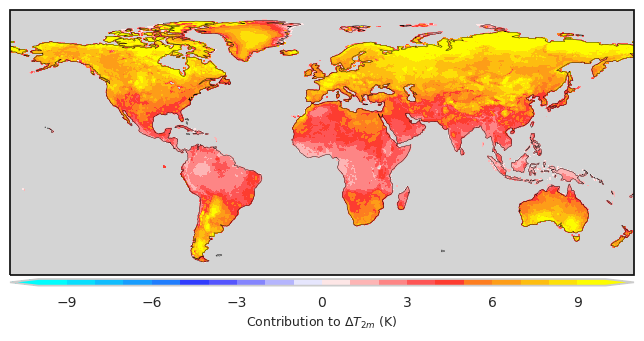

plot ADV
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


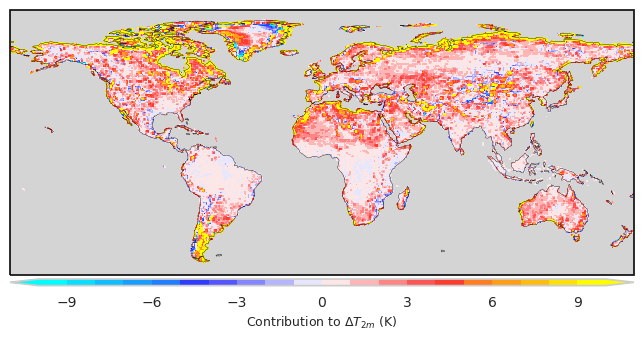

plot Adiabatic
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


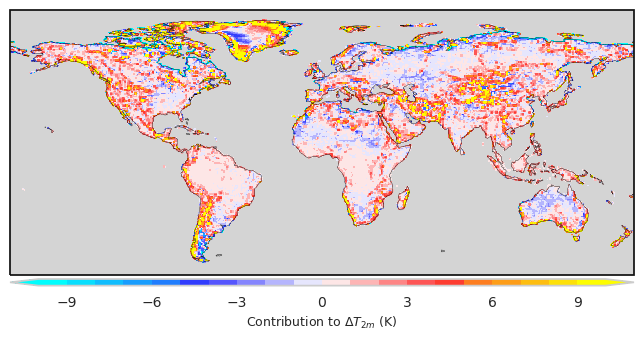

plot Rs
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


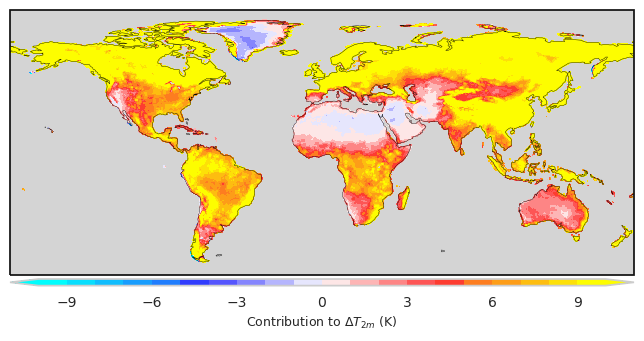

plot Rld
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


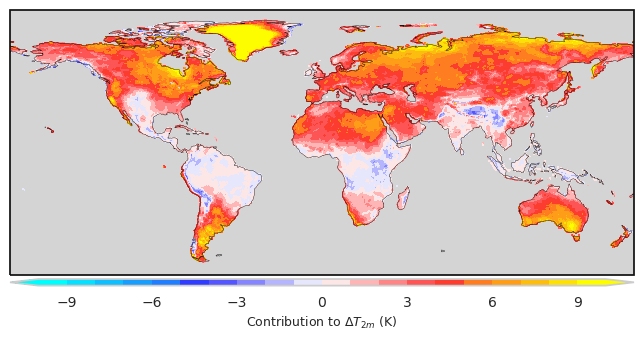

plot LE
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


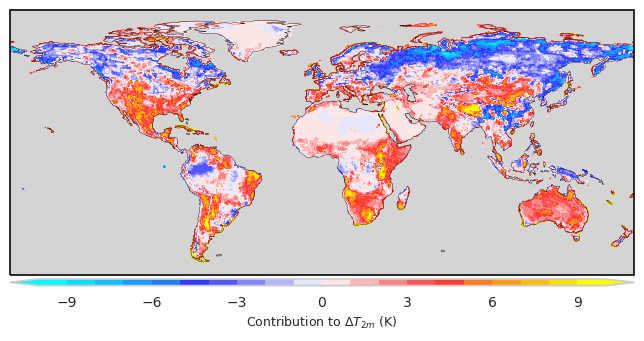

plot H
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


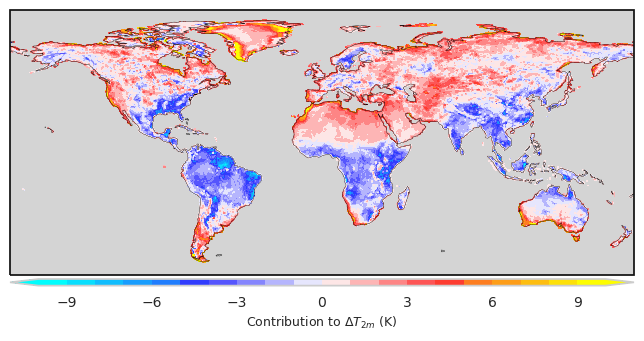

plot Q
[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


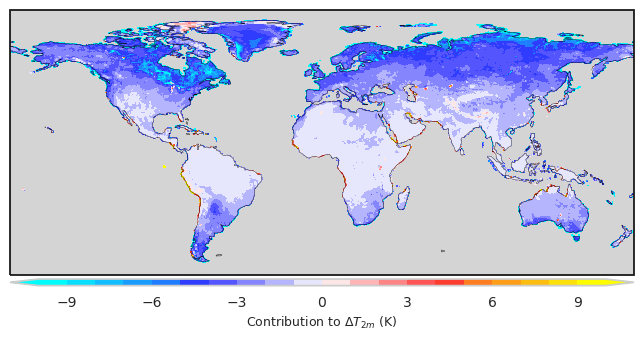

In [16]:

for HW_plot_all, savename in zip ([HW_t2m_all,HW_dia_all,HW_adv_all,HW_adiabatic_all, HW_ssr_all,HW_strd_all,HW_slhf_all,HW_sshf_all,HW_q_all],
['T2m','Diabatic','ADV','Adiabatic','Rs','Rld','LE','H','Q']):

    plot_map = np.zeros((720,1440))*0.0
    f_map = np.zeros((720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]

        plot_temp = HW_plot_all[i_k]
        
        for i,j,kk in zip(yy,xx,plot_temp ):
            if np.isnan(kk):
                continue
            plot_map[i,j]=plot_map[i,j]+kk
            f_map[i,j]=f_map[i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    plot_map = plot_map/f_map

    if savename=='Diabatic':
        plot_map=0.92*plot_map

    #%%
    cmap  = cmaps.cmp_flux
    print('plot '+ savename)
    fig= plt.figure(figsize=(6.5,3.3))
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.02, 0.15, 0.96, 0.85],projection = proj)
    #ax.text(0.02, 1.1,'Heatwave visit frequency',fontsize=15,transform=ax.transAxes)
    ax.set_facecolor('#d4d4d4')
    con_value = plot_map
    con_value[land_mask<0.1]=np.nan
    #con_value[con_value==0]=np.nan
    #cmap = cm.Blues
    #cmap.set_bad('white',0)
    cmap.set_bad('#d4d4d4',np.nan)
    all_value = np.array([np.abs(iiii) for iiii in con_value[(~np.isnan(con_value))&(con_value!=0)]])
    bnd = np.max((np.abs(np.nanpercentile(all_value,25)),np.abs(np.nanpercentile(all_value,75))))
    #print(bnd)
    if bnd==0:
        bnd=0.01
    levels = np.linspace(-10,10,21)
    print(levels)
    con  = ax.contourf(LON_era5,LAT_era5,con_value,levels,extend='both',cmap=cmap)

    ax.coastlines()
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.spines['geo'].set_color('k')
    
    cax = plt.axes([0.02, 0.14, 0.96, 0.02])
    cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8)
    if savename!='T2m':
        cbar.set_label('Contribution to $\Delta$$T_{2m}$ (K)',fontsize=9)
    else:
        cbar.set_label('$\Delta$$T_{2m}$ (K)',fontsize=9)
    pyplot.show()

    fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/Decompositon_pattern_'+savename+vername+'.jpg', dpi=300)

# Clustering

In [28]:

HW_SEB_all = []
HW_SEB_all1 = []
for iii in range(len(HW_slhf_all)):
    SEB_event = np.array([ HW_adv_all[iii],HW_adiabatic_all[iii],HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
    for ii in  SEB_event:
        if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
            #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
            continue
        else:
            HW_SEB_all.append(np.array([ii/np.sum([np.abs(k) for k in ii])]))
            HW_SEB_all1.append(np.array(ii))
HW_SEB_all = np.squeeze( np.array(HW_SEB_all))
HW_SEB_all1 = np.squeeze( np.array(HW_SEB_all1))


In [29]:
len(HW_SEB_all1)

8463177

In [51]:

print('start kmeans n=4')
km = KMeans(n_clusters=4, random_state=42)
km.fit_predict(HW_SEB_all)
HW_labels_all1 = km.labels_

HW_labels_all = []

nnn=0
for iii in range(len(HW_slhf_all)):
    HW_labels_temp = []
    SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
    for ii in  SEB_event:
        if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
            HW_labels_temp.append(np.nan)
            continue
        else:
            HW_labels_temp.append(HW_labels_all1[nnn])
            nnn=nnn+1
    HW_labels_all.append(np.array(HW_labels_temp ))
HW_labels_all = np.array(HW_labels_all)

start kmeans n=4


/tmp/ipykernel_3802508/1305031188.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  HW_labels_all = np.array(HW_labels_all)


In [52]:
vername = '_235'
with open(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels'+vername+'.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(HW_labels_all)
    print('cluster end')

cluster end


# Clustering read

In [30]:
vername = '_235'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_labels'+vername+'.csv'
HW_labels_all1 = []
HW_AI_all1 = []
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        temp = []
        for i_i,i in enumerate(row):
            if np.isnan(float(i)):
                temp.append(np.nan)
                HW_AI_all1.append(np.nan)
            else:
                temp.append(round(float(i)))
                HW_labels_all1.append(round(float(i)))
                HW_AI_all1.append(float(HW_AI_all[i_row][i_i]))
        all.append(np.array(temp))
HW_labels_all = copy.deepcopy(all)
HW_labels_all1 = np.array(HW_labels_all1)
HW_AI_all1 = np.array(HW_AI_all1)


In [31]:

label_name = [3,0,1,2]

# AI

In [32]:
HW_AI_all1[HW_AI_all1<0]=0
HW_AI_all1[HW_AI_all1>10]=10

/tmp/ipykernel_3815113/1527928174.py:24: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


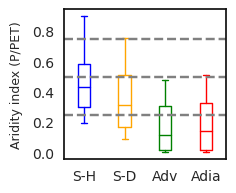

In [153]:

fig= plt.figure(figsize=(2.5, 2))
ax = plt.axes([0.3, 0.2, 0.65, 0.75])


plot_temp = HW_AI_all1


for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
    
    bplot = ax.boxplot(plot_temp[HW_labels_all1==box_position][~np.isnan(plot_temp[HW_labels_all1==box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot[element] :
            plt.setp(patch, color=c)


ax.axhline(y = 0.25, color = 'grey', linestyle = '--')
ax.axhline(y = 0.5, color = 'grey', linestyle = '--')
ax.axhline(y = 0.75, color = 'grey', linestyle = '--')

for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')  
ax.set_ylabel('Aridity index (P/PET)',labelpad=0.02,fontsize=9) 

ax.grid(b=False)




ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)

ax.yaxis.set_label_coords(-.25, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.05,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/AI.jpg', dpi=300)

# Distribution of clustering

In [33]:
label_map = np.zeros((4,720,1440))
nn = 0
for i_k  in np.arange(event_N):
    # if HW_size_label[i_k]==1:
    #     continue
    xx = HW_lon[i_k]
    yy = HW_lat[i_k]
    zz = HW_labels_all[i_k]
    for i,j,k in zip(yy,xx,zz):
        label_map[k,i,j]=label_map[k,i,j]+1
    nn = nn+1

In [34]:
label_map1 = np.zeros((4,720,1440))
for i in range(4):
    label_map1[i]=label_map[label_name[i]]
label_map1.dump(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/label_map'+vername+'.csv')


In [35]:
for i_label in label_name:
    print(len(HW_labels_all1[HW_labels_all1==i_label]))

3090207
2080936
2110496
1181538


In [36]:
len(HW_labels_all1)

8463177

In [37]:
len(HW_ssr_all)

3454

In [38]:
color_heat = '#c84b31'
color_cold = '#2d4263'

In [39]:

Significance_all0 = []
for var_name in ['adv','adiabatic','ssr','strd','slhf','sshf','sshf']:
    Significance_all0.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all0 = np.array(Significance_all0)

# Fig. 1

/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
findfont: Fon

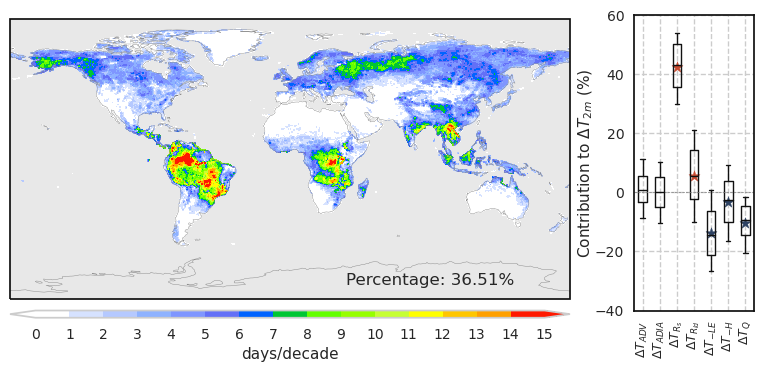

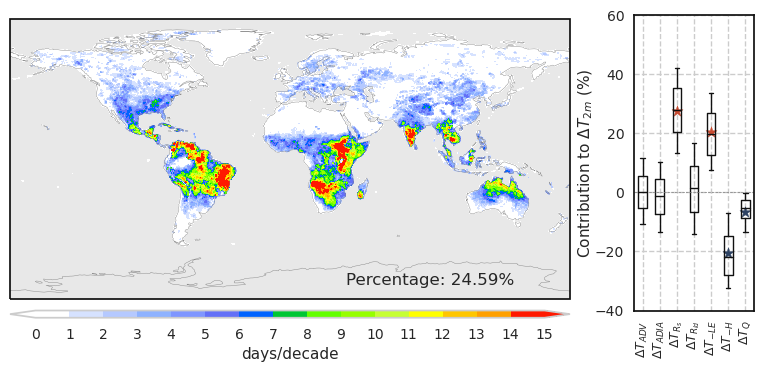

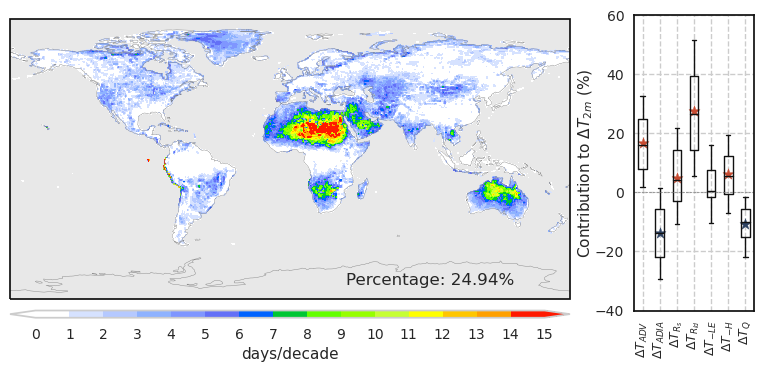

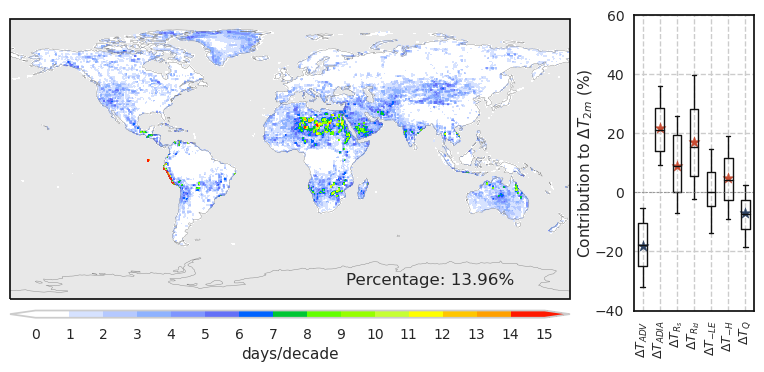

In [40]:
# Fig. 1
vername = '_235'
nn=0
for i_label,cmap in zip(label_name,[cm.Blues,cm.Oranges,cm.Greens,cm.Purples,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds]):
    nn=nn+1
    cmap =cmaps.precip3_16lev
    fig= plt.figure(figsize=(8, 3.6))
    proj = ccrs.PlateCarree(central_longitude=0)##
    ax = plt.axes([0.02, 0.17, 0.7, 0.8],projection = proj)
    ax.set_facecolor('#E8E8E8')
    ax.text(0.6, 0.05,'Percentage: %.2f' % (100*len(HW_labels_all1[HW_labels_all1==i_label])/len(HW_labels_all1))+'%',fontsize=12,transform=ax.transAxes)

    con_value = label_map[i_label]/4.2
    con_value[LAT_era5<-60]=np.nan
    con_value[land_mask<0.1]=np.nan

    levels = MaxNLocator(nbins=15).tick_values(0, 15)
    norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

  
    im = ax.contourf(LON_era5,LAT_era5, con_value, extend='both',levels=levels, cmap=cmap, norm=norm)
    ax.coastlines(color='grey')
    # ax.gridlines()
    # ax.set_xticks([-180, -120, -60,0, 60, 120, 180, ], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True,
                                    number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.set_extent([-180, 180, -90, 90])

    rect = patches.Rectangle((90, 27), 103-90+1, 40-27+1, linewidth=1, edgecolor='r', facecolor='none')
    #ax.add_patch(rect)
    cax = plt.axes([0.02, 0.13, 0.7, 0.02])

    #ax1.grid(b=False)

    cbar = plt.colorbar(im,cax=cax,orientation='horizontal', shrink=0.8)
    cbar.set_label('days/decade')
    cax.set_xticks(np.arange(0,16,1))
    cax.set_xticklabels(np.arange(0,16,1))
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.spines['geo'].set_color('k')
        
    ax = plt.axes([0.8, 0.15, 0.15, 0.82])


    bplot1 = ax.boxplot(np.array(HW_SEB_all)[HW_labels_all1==i_label]*100, positions=np.arange(1,8), whis = [10, 90],showfliers=False)

    scatter_plot = np.nanmean(HW_SEB_all[HW_labels_all1==i_label],axis=0)*100


    sig_max = np.nanmax( Significance_all0[:,i_label,:] ,axis=1)
    sig_min = np.nanmin( Significance_all0[:,i_label,:] ,axis=1)
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan

    ax.scatter(np.arange(1,8)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = '*',color=color_heat,s=70)
    ax.scatter(np.arange(1,8)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = '*',color=color_cold,s=70)
    ax.axhline(y = 0, color = 'grey', linestyle = '--',linewidth=0.5)
    ax.set_xticks(range(1,8))
    ax.set_xticklabels(['${\Delta}$$T_{ADV}$','${\Delta}$$T_{ADIA}$','${\Delta}$$T_{R_{s}}$','${\Delta}$$T_{R_{ld}}$','${\Delta}$$T_{-LE}$','${\Delta}$$T_{-H}$','${\Delta}$$T_{Q}$'],rotation=90,fontsize=9)    
    ax.set_ylabel('Contribution to $\Delta$$T_{2m}$ (%)',labelpad=0.1)
    ax.set_ylim(-40,60)

    # for element in ['whiskers','caps','medians','boxes']:
    #     for patch in bplot[element] :
    #         plt.setp(patch, color='gray')


    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot1[element] :
            plt.setp(patch, color='k')

    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(linestyle='--')
    fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_visit frequency'+str(nn)+vername+'.jpg', dpi=300)

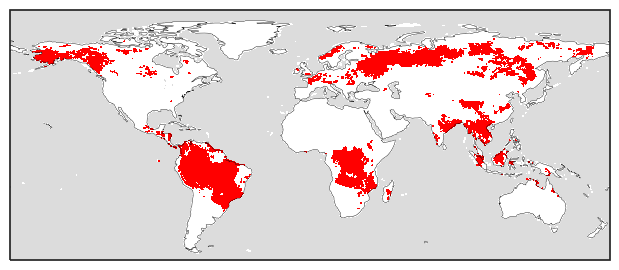

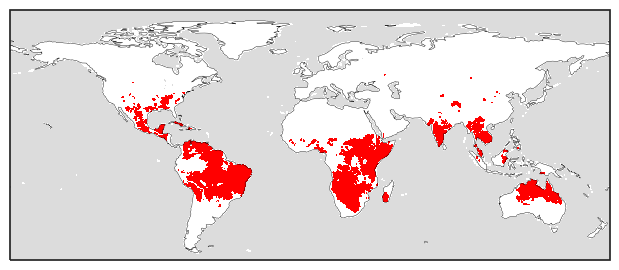

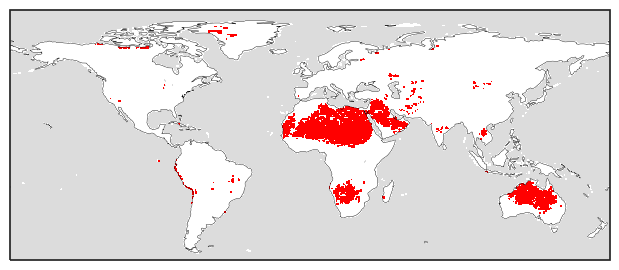

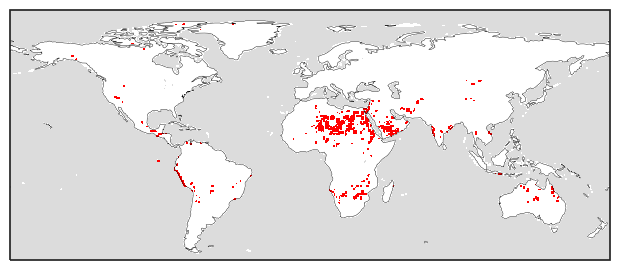

In [66]:

for i_label,cmap in zip(label_name,[cm.Blues,cm.Oranges,cm.Greens,cm.Purples,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds,cm.Reds]):
    cmap =cmaps.precip3_16lev
    fig= plt.figure(figsize=(6, 3))
    proj = ccrs.PlateCarree()##
    ax = plt.axes([0.0, 0.0, 1, 1],projection = proj)

    ax.set_facecolor('#DCDCDC')
    con_value = copy.deepcopy(label_map[i_label])
    con_value[LAT_era5<-60]=np.nan
    con_value[land_mask<0.1]=np.nan
    con_value[con_value<=21]=np.nan

    #cmap = cm.Blues
    #cmap.set_bad('white',0)

    land_mask_mask = copy.deepcopy(land_mask)
    land_mask_mask[land_mask<0.1]=np.nan
    land_mask_mask[LAT_era5<-60]=np.nan

    ax.contourf(LON_era5,LAT_era5, land_mask_mask, colors='white')
    ax.contourf(LON_era5,LAT_era5, con_value, colors='red')

    ax.set_extent((-179.5, 180., -60., 90.))

    ax.coastlines()

    fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_highlight'+str(i_label)+vername+'.jpg', dpi=300)

# Lead lag

In [67]:
vername = '_235'
var = 't2m'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_t2m_all_leadlag = copy.deepcopy(all) 

vername = '_235'
var = 'skt'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_skt_all_leadlag = copy.deepcopy(all) 

var = 'ssr'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_ssr_all_leadlag = copy.deepcopy(all)

#

var = 'strd'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_strd_all_leadlag = copy.deepcopy(all)

#

var = 'sshf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_sshf_all_leadlag = copy.deepcopy(all)

#

var = 'slhf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_slhf_all_leadlag = copy.deepcopy(all)

var = 'adv'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_adv_all_leadlag = copy.deepcopy(all)

var = 'adiabatic'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_leadlag.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all1 = []
        for j in row:
            all1.append(np.array([ float(i) for i in j[1:-1].split()]))
        all.append(np.array(all1))
HW_adiabatic_all_leadlag = copy.deepcopy(all)

HW_q_all_leadlag = []  
for iii in range(len(HW_slhf_all)):
    HW_q_all_leadlag.append(HW_skt_all_leadlag[iii]-HW_ssr_all_leadlag[iii]-HW_strd_all_leadlag[iii]-HW_slhf_all_leadlag[iii]-HW_sshf_all_leadlag[iii])




/tmp/ipykernel_3802508/3102272302.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all.append(np.array(all1))
/tmp/ipykernel_3802508/3102272302.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all.append(np.array(all1))
/tmp/ipykernel_3802508/3102272302.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all.append(np.array

In [ ]:
HW_t2m_all_leadlag_all = []
HW_adv_all_leadlag_all = []
HW_adiabatic_all_leadlag_all = []
HW_ssr_all_leadlag_all = []
HW_strd_all_leadlag_all = []
HW_slhf_all_leadlag_all = []
HW_sshf_all_leadlag_all = []
HW_q_all_leadlag_all = []
for iii in range(len(HW_slhf_all)):
    
    SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
    for jjj,ii in  enumerate(SEB_event):
        if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
            #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
            continue
        else:
            kkk = np.array([HW_adv_all_leadlag[iii][jjj],HW_adiabatic_all_leadlag[iii][jjj],HW_ssr_all_leadlag[iii][jjj],HW_strd_all_leadlag[iii][jjj],HW_slhf_all_leadlag[iii][jjj],HW_sshf_all_leadlag[iii][jjj],HW_q_all_leadlag[iii][jjj]])
            kkk1 = np.array(7*[np.sum([np.abs(k) for k in kkk],axis=0)])
            #kkk = kkk/kkk1
            HW_t2m_all_leadlag_all.append(HW_t2m_all_leadlag[iii][jjj]+0.3*np.array(kkk[6]))
            HW_adv_all_leadlag_all.append(np.array(kkk[0]))
            HW_adiabatic_all_leadlag_all.append(np.array(kkk[1]))
            HW_ssr_all_leadlag_all.append(np.array(kkk[2]))
            HW_strd_all_leadlag_all.append(np.array(kkk[3]))
            HW_slhf_all_leadlag_all.append(np.array(kkk[4]))
            HW_sshf_all_leadlag_all.append(np.array(kkk[5]))
            HW_q_all_leadlag_all.append(0.7*np.array(kkk[6]))
HW_t2m_all_leadlag_all = np.squeeze( np.array(HW_t2m_all_leadlag_all))
HW_adv_all_leadlag_all = np.squeeze( np.array(HW_adv_all_leadlag_all))
HW_adiabatic_all_leadlag_all = np.squeeze( np.array(HW_adiabatic_all_leadlag_all))
HW_ssr_all_leadlag_all = np.squeeze( np.array(HW_ssr_all_leadlag_all))
HW_strd_all_leadlag_all = np.squeeze( np.array(HW_strd_all_leadlag_all))
HW_slhf_all_leadlag_all = np.squeeze( np.array(HW_slhf_all_leadlag_all))
HW_sshf_all_leadlag_all = np.squeeze( np.array(HW_sshf_all_leadlag_all))
HW_q_all_leadlag_all = np.squeeze( np.array(HW_q_all_leadlag_all))


In [ ]:
leadlag_all =[HW_t2m_all_leadlag_all,HW_adv_all_leadlag_all,HW_adiabatic_all_leadlag_all,HW_ssr_all_leadlag_all,HW_strd_all_leadlag_all,HW_slhf_all_leadlag_all,HW_sshf_all_leadlag_all,HW_q_all_leadlag_all]

In [ ]:
colors = ['#000000','#EE6677','#228833','#AA3377','#4477AA','#CCBB44','#66CCEE','#BBBBBB']

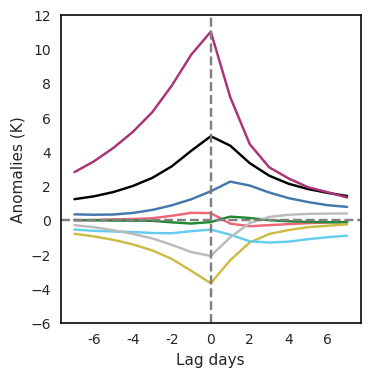

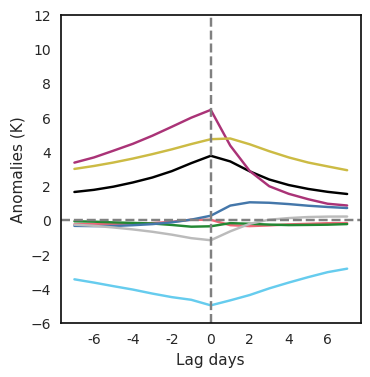

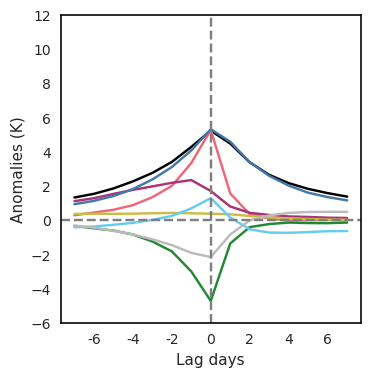

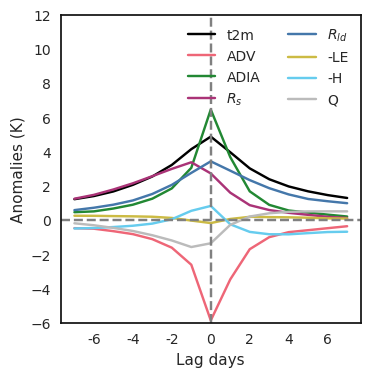

In [ ]:

for ln in [0,1,2,3]:
    fig,ax = plt.subplots(figsize=(4, 4),ncols=1,nrows=1)

    for plot_temp,ylabel,y_n in zip(leadlag_all,['t2m','ADV','ADIA','$R_{s}$','$R_{ld}$','-LE','-H','Q'],range(8)):
        i_len = np.array( [len(i) for i in plot_temp])
        plot_temp_new = []
        for i in plot_temp:
            if len(i)==15:
                plot_temp_new.append(i)
        plot_temp_new = np.array(plot_temp_new)
        # if ylabel=='t2m':

        #     ax.plot(np.nanmean(plot_temp[np.in1d(HW_labels_all1,label_name[1])],axis=0),label=ylabel)
        #     #ax.fill_between(x=np.arange(15),y1=np.nanpercentile(plot_temp[np.in1d(HW_labels_all1,label_name[0])],5,axis=0),y2=np.nanpercentile(plot_temp[np.in1d(HW_labels_all1,label_name[0])],95,axis=0),alpha=0.1,color='b')
        #     #continue
        # else:

        ax.plot(np.nanmean(plot_temp_new[np.in1d(HW_labels_all1[i_len==15],label_name[ln])],axis=0),label=ylabel,color=colors[y_n])
    if ln==3:
        plt.legend(ncol=2)
    plt.grid(False)
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    plt.axhline(y = 0, color = 'grey', linestyle = '--')
    plt.axvline(x = 7, color = 'grey', linestyle = '--')
    plt.xticks(range(1,15,2),range(-6,8,2))
    plt.ylabel('Anomalies (K)')
    plt.xlabel('Lag days')
    plt.ylim((-6,12))
    plt.subplots_adjust(left=0.2,right=0.95)
    fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_leadlag'+str(ln)+'.jpg', dpi=300)

# Attribution

In [28]:
vername = '_235'
Significance_all1 = []
for var_name in ['z500','tcc','swvl1']:
    Significance_all1.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all1 = np.array(Significance_all1)
Significance_all1[0] = Significance_all1[0]/100
Significance_all1[1] = Significance_all1[1]*100
Significance_all1[2] = Significance_all1[2]*1000


Significance_all2 = []
for var_name in ['u_dT','du_T','v_dT','dv_T','omega']:
    Significance_all2.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all2 = np.array(Significance_all2)



In [29]:
Significance_all21 = np.array([Significance_all2 [0]+Significance_all2 [1],Significance_all2 [2]+Significance_all2 [3],Significance_all2 [4]])

In [30]:
vername = '_235'
var = 'z500'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])/100)
HW_z500_all = copy.deepcopy(all)

var = 'tcc'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])*100)
HW_tcc_all = copy.deepcopy(all)



var = 'swvl1'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([ float(i) for i in row])*1000)
HW_swvl1_all = copy.deepcopy(all)



In [31]:

var = 'dv_T'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_dv_T_all = copy.deepcopy(all)

var = 'du_T'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_du_T_all = copy.deepcopy(all)

var = 'v_dT'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_v_dT_all = copy.deepcopy(all)

var = 'u_dT'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_u_dT_all = copy.deepcopy(all)

var = 'omega'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_omega_all = copy.deepcopy(all)

In [32]:
var_map1 = []
for var_all in [HW_z500_all,HW_tcc_all,HW_swvl1_all]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    temp_map 
    var_map1.append(temp_map)
    
var_map2 = []
for var_all in [HW_u_dT_all+HW_v_dT_all,HW_du_T_all+HW_dv_T_all,HW_omega_all]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    var_map2.append(temp_map)

# Fig. 2a-2c

[9.55162976 2.83535264 6.50243983 5.75601671]
[-29.99491131 -21.85543281          nan  -5.60634774]
[-64.14939247 -89.68055979          nan          nan]


/tmp/ipykernel_3815113/3570955723.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/tmp/ipykernel_3815113/3570955723.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/tmp/ipykernel_3815113/3570955723.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


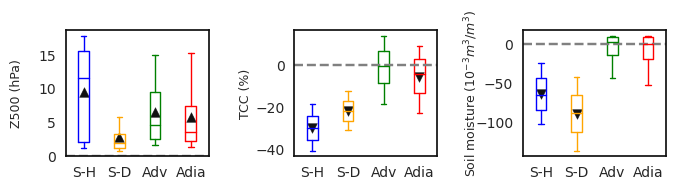

In [70]:


fig,axs = plt.subplots(figsize=(7.5, 2),ncols=3,nrows=1)
for var_number,ylabel in zip(range(4),['Z500 (hPa)','TCC (%)','Soil moisture ($10^{-3}$$m^{3}$/$m^{3}$)']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map1[var_number])

    all_data = []
    for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
        all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
        bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
        for element in ['whiskers','caps','medians','boxes']:
            for patch in bplot[element] :
                plt.setp(patch, color=c)

    
    all_data = np.array(all_data)
    scatter_plot = all_data
    sig_max = np.nanmax( Significance_all1[var_number,:,:] ,axis=1)[label_name]
    sig_min = np.nanmin( Significance_all1[var_number,:,:] ,axis=1)[label_name]
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan

    print(scatter_plot)
    ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
    ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')
    ax.axhline(y = 0, color = 'grey', linestyle = '--')


    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(b=False)

    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)
    ax.yaxis.set_label_coords(-.3, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_disbalance_hydro_'+vername+'.jpg', dpi=300)

# Fig. 2d-2f

[        nan         nan  0.00320422 -0.00418719]
[        nan         nan  0.01440336 -0.01888478]


/tmp/ipykernel_3815113/463069580.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)
/tmp/ipykernel_3815113/463069580.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


[       nan        nan        nan 0.03681812]


/tmp/ipykernel_3815113/463069580.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


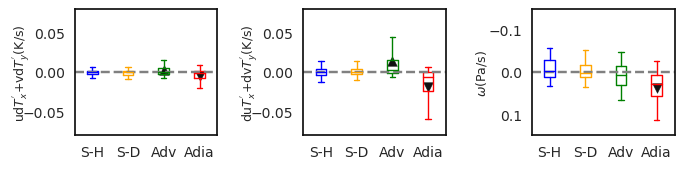

In [71]:


fig,axs = plt.subplots(figsize=(7.5, 2),ncols=3,nrows=1)
for var_number,ylabel in zip(range(4),['ud$T^{\'}_x$+vd$T^{\'}_y$(K/s)','du$T^{\'}_x$+dv$T^{\'}_y$(K/s)','${\omega}$(Pa/s)']):
    ax = axs[var_number]
    plot_temp = copy.deepcopy(var_map2[var_number])

    all_data = []
    for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
        all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
        bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
        for element in ['whiskers','caps','medians','boxes']:
            for patch in bplot[element] :
                plt.setp(patch, color=c)

    
    all_data = np.array(all_data)
    scatter_plot = all_data
    sig_max = np.nanmax( Significance_all2[var_number,:,:] ,axis=1)[label_name]
    sig_min = np.nanmin( Significance_all2[var_number,:,:] ,axis=1)[label_name]
    scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan


    print(scatter_plot)
    ax.axhline(y = 0, color = 'grey', linestyle = '--')



    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')  
    ax.set_ylabel(ylabel,labelpad=0.02,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
    ax.grid(b=False)
    # w = ax.get_xaxis()
    # w.set_visible(False)
    if var_number==2:
        ax.set_ylim(-0.15,0.15)
        ax.invert_yaxis()
        ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "v",color='k')
        ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "^",color='k')
    else:
        ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
        ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')      
        ax.set_ylim(-0.08,0.08)
    ax.set_xticks([1,2,3,4])
    ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)
    ax.yaxis.set_label_coords(-.3, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_disbalance_meteoro'+vername+'.jpg', dpi=300)

# Impact on carbon cycle monthly_detrend

In [73]:
Significance_all3 = []
for var_name in ['GPP','TER','NEE']:
    Significance_all3.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_monthly'+vername+'_detrend_weighted.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all3 = np.array(Significance_all3)

Significance_all3[0] = Significance_all3[0]
Significance_all3[1] = Significance_all3[1]
Significance_all3[2] = Significance_all3[2]


In [74]:

var = 'GPP'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_GPP_all1 = copy.deepcopy(all)

var = 'TER'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_TER_all1 = copy.deepcopy(all)

var = 'NEE'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_NEE_all1 = copy.deepcopy(all)


In [75]:
var_map3 = []
for var_all in [ HW_GPP_all1,HW_TER_all1,HW_NEE_all1]:
    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    var_map3.append(temp_map)

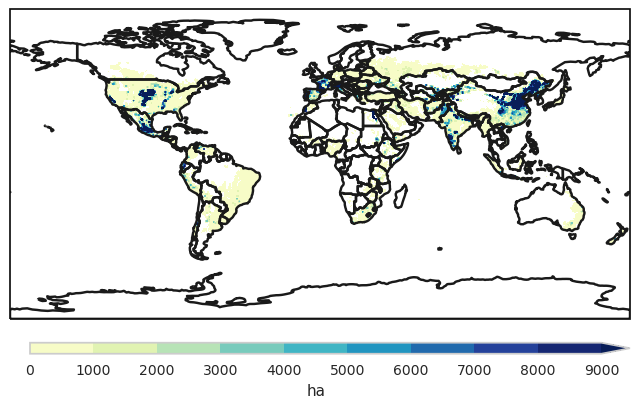

In [76]:
HA_grid = np.loadtxt('/Net/Groups/BGI/scratch/yt/data/harvested_area_grids/annual_area_harvested_irc_crop02_ha_30mn.asc', skiprows=6)
a = np.zeros_like(LON_era5)


a[::2,::2]=HA_grid[:,:]
a[::2,1::2]=HA_grid[:,:]

a[1::2,::2]=HA_grid[:,:]
a[1::2,1::2]=HA_grid[:,:]


a[a<=0]=np.nan

area = copy.deepcopy(a)

import regionmask

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.arange(0,10000,1000),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.arange(0,10000,1000))
cbar.set_label('ha')
#cbar.set_xticks(levels=np.hstack([10,np.arange(100,1100,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
#plt.colorbar(con)
area = copy.deepcopy(a)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
ax.spines['geo'].set_color('k')
f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/harvest_area.jpg', dpi=300)

# Fig. 3b

In [79]:
a_all = []
for i in range(4):
    a_all.append(area)
a_all = np.array(a_all)

[-0.05190692 -0.08333892         nan         nan]


/tmp/ipykernel_3815113/530103926.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


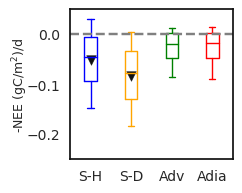

In [80]:
# HW_Meteoro
var_number=2
fig= plt.figure(figsize=(2.5, 2))
ax = plt.axes([0.3, 0.2, 0.65, 0.75])
plot_temp = copy.deepcopy(var_map3[var_number])

plot_temp = -plot_temp
plot_temp[np.isnan(a_all)]=np.nan
all_data = []
for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
    all_data.append(np.nanmean(plot_temp[box_position][(~np.isnan(plot_temp[box_position]))]))
    bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot[element] :
            plt.setp(patch, color=c)


all_data = np.array(all_data)
scatter_plot = copy.deepcopy(all_data)

sig_max = np.nanpercentile( Significance_all3[var_number,:,:] ,99.9,axis=1)[label_name]
sig_min = np.nanpercentile( Significance_all3[var_number,:,:] ,0.1,axis=1)[label_name]
scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan

ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')
ax.axhline(y = 0, color = 'grey', linestyle = '--')



for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')  
ax.set_ylabel('-NEE (gC/m$^2$)/d',labelpad=0.02,fontsize=9) 

ax.grid(b=False)
# w = ax.get_xaxis()
# w.set_visible(False)

ax.set_ylim(-0.25,0.05)

print(scatter_plot)
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)

ax.yaxis.set_label_coords(-.25, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.05,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_NEE'+vername+'_detrend_harvest.jpg', dpi=300)

# Impact on human daily_detrend

In [81]:
import regionmask
NCname = r'/Net/Groups/BGI/scratch/yt/data/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_totpop_1_deg_nc/gpw_v4_population_density_adjusted_rev11_1_deg.nc'
NCData = Dataset(NCname)
lon_PD = NCData.variables['longitude'][:]
lat_PD = NCData.variables['latitude'][:]
LON_PD, LAT_PD = np.meshgrid(lon_PD, lat_PD)
PD = NCData.variables['UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree'][:]
PD[PD<0] = np.nan

a = np.zeros_like(LON_era5)


a[::4,::4]=PD[4][:,:]
a[::4,1::4]=PD[4][:,:]
a[::4,2::4]=PD[4][:,:]
a[::4,3::4]=PD[4][:,:]

a[1::4,::4]=PD[4][:,:]
a[1::4,1::4]=PD[4][:,:]
a[1::4,2::4]=PD[4][:,:]
a[1::4,3::4]=PD[4][:,:]

a[2::4,::4]=PD[4][:,:]
a[2::4,1::4]=PD[4][:,:]
a[2::4,2::4]=PD[4][:,:]
a[2::4,3::4]=PD[4][:,:]

a[3::4,::4]=PD[4][:,:]
a[3::4,1::4]=PD[4][:,:]
a[3::4,2::4]=PD[4][:,:]
a[3::4,3::4]=PD[4][:,:]




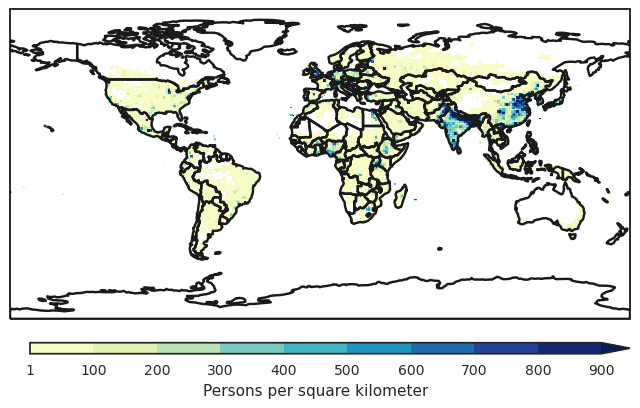

In [82]:
a[a<1]=np.nan
a[land_mask<0.1]=np.nan

f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()
con = ax.contourf(LON_era5, LAT_era5,a,cmap='YlGnBu',levels=np.hstack([1,np.arange(100,1000,100)]),extend='max')
cax = plt.axes([0.15,0.15, 0.75, 0.02])
cbar = plt.colorbar(con,cax=cax,orientation='horizontal', shrink=0.8,ticks=np.hstack([1,np.arange(100,1000,100)]))
cbar.set_label('Persons per square kilometer')
#cbar.set_xticks(levels=np.hstack([1,np.arange(100,1000,100)]))
regionmask.defined_regions.natural_earth_v5_0_0.countries_110.plot(ax=ax,add_label=False)
for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k') 
area = copy.deepcopy(a)
ax.spines['geo'].set_color('k')
f.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/population_density.jpg', dpi=300)

In [82]:
Significance_all4 = []
for var_name in ['t2m','Twet','utci']:
    Significance_all4.append(np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/strict_significance_'+var_name+'_daily_detrend.nc') ['__xarray_dataarray_variable__'][:][:]))
#Significance_all = np.transpose(np.array(Significance_all), (1, 2,0))
Significance_all4 = np.array(Significance_all4)

In [83]:
vername = '_235'


var = 'rH_cf'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_rH_cf_all = copy.deepcopy(all)

var = 'tsi'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_HSI_all = copy.deepcopy(all)

var = 'Twet'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_Twet_all = copy.deepcopy(all)

var = 't2m'
flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_025_degree/HW_'+var+'_ano_6days_all'+vername+'_detrend.csv'
with open(flname, 'r') as file:
    reader = csv.reader(file)
    all = []
    for i_row,row in enumerate(reader):
        all.append(np.array([float(i) for i in row]))
HW_t2m_all = copy.deepcopy(all)

In [84]:
var_map4 = []
for var_all in  [HW_t2m_all,HW_Twet_all,HW_rH_cf_all,HW_HSI_all]:

    temp_map = np.zeros((4,720,1440))
    f_map = np.zeros((4,720,1440))
    nn = 0
    for i_k  in np.arange(event_N):
        # if HW_size_label[i_k]==1:
        #     continue
        xx = HW_lon[i_k]
        yy = HW_lat[i_k]
        zz = HW_labels_all[i_k]
        temp_temp = var_all[i_k]
        for i,j,k,kk in zip(yy,xx,zz,temp_temp):
            if np.isnan(kk):
                continue
            if (kk>100)|(kk<-100):
                continue
            # k_where = np.where(np.in1d(label_name,k))[0][0]
            temp_map[k,i,j]=temp_map[k,i,j]+kk
            f_map[k,i,j]=f_map[k,i,j]+1
        nn = nn+1
    f_map[f_map==0]=np.nan
    temp_map = temp_map/f_map
    temp_map 
    var_map4.append(temp_map)

In [85]:
var_map41 = copy.deepcopy(np.array([var_map4[0],var_map4[1],var_map4[3]]))

# Fig. 3d

In [117]:
a_all = []
for i in range(4):
    a_all.append(a)
a_all = np.array(a_all)

[5.53843456 3.29451421 8.58194703 4.88323779]


/tmp/ipykernel_3815113/972600219.py:36: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=False)


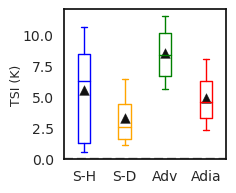

In [118]:
# HW_Meteoro

fig= plt.figure(figsize=(2.5, 2))
ax = plt.axes([0.3, 0.2, 0.65, 0.75])
plot_temp = copy.deepcopy(var_map41[2])

plot_temp[np.isnan(a_all)] = np.nan

all_data = []
for pos,box_position,c in zip(range(4),label_name,['blue','orange','green','red']):
    all_data.append(np.nanmean(plot_temp[box_position][~np.isnan(plot_temp[box_position])]))
    bplot = ax.boxplot(plot_temp[box_position][~np.isnan(plot_temp[box_position])],widths=0.3, positions=[pos+1],whis = [10, 90],showfliers=False)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bplot[element] :
            plt.setp(patch, color=c)


all_data = np.array(all_data)
scatter_plot = copy.deepcopy(all_data)

sig_max = np.nanmax( Significance_all4[2,:,:] ,axis=1)[label_name]
sig_min = np.nanmin( Significance_all4[2,:,:] ,axis=1)[label_name]

scatter_plot[(scatter_plot>sig_min)&(scatter_plot<sig_max)]=np.nan
print(scatter_plot)
ax.scatter(np.arange(1,5)[scatter_plot>0],scatter_plot[scatter_plot>0],marker = "^",color='k')
ax.scatter(np.arange(1,5)[scatter_plot<0],scatter_plot[scatter_plot<0],marker = "v",color='k')
ax.axhline(y = 0, color = 'grey', linestyle = '--')



for bnd in ['bottom','top','right','left']:
    ax.spines[bnd].set_color('k')  
ax.set_ylabel('TSI (K)',labelpad=0.02,fontsize=9) 

ax.grid(b=False)

# ax.set_ylim(0,10)


ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['S-H','S-D','Adv','Adia'],fontsize=10)

ax.yaxis.set_label_coords(-.25, .5)
plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.05,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6_025/HW_HSI'+vername+'_detrend_populated.jpg', dpi=300)